# Imports

In [236]:
using DataFrames
using CSV
using MLJ
using Flux
using Plots
using StatsBase
using MLJ: confusion_matrix

include("../../lib.jl")

ENV["LINES"]=50;

In [237]:
mkdir("./Figures")

LoadError: IOError: mkdir: file already exists (EEXIST)

# Datasets

In [238]:
data = CSV.read("data.csv")

,Class_Name,Left_Weight,Left_Distance,Right_Weight,Right_Distance
,String,Int64,Int64,Int64,Int64
1,B,1,1,1,1
2,R,1,1,1,2
3,R,1,1,1,3
4,R,1,1,1,4
5,R,1,1,1,5
6,R,1,1,2,1
7,R,1,1,2,2
8,R,1,1,2,3
9,R,1,1,2,4


In [239]:
describe(data)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Nothing,DataType
1,Class_Name,,B,,R,3,,String
2,Left_Weight,3.0,1,3.0,5,,,Int64
3,Left_Distance,3.0,1,3.0,5,,,Int64
4,Right_Weight,3.0,1,3.0,5,,,Int64
5,Right_Distance,3.0,1,3.0,5,,,Int64


Look at class labels to see if dataset is imbalanced

In [240]:
label_counts = countmap(data[:Class_Name])

Dict{String,Int64} with 3 entries:
  "B" => 49
  "L" => 288
  "R" => 288

In [241]:
collect(label_counts[i] / size(data)[1] for i in keys(label_counts))

3-element Array{Float64,1}:
 0.0784
 0.4608
 0.4608

Get data ready for training

In [242]:
coerce!(data, :Class_Name=>Multiclass,
              :Left_Weight=>Continuous,
              :Right_Weight=>Continuous,
              :Left_Distance=>Continuous,
              :Right_Distance=>Continuous)
schema(data)

┌────────────────┬─────────────────────────────────┬───────────────┐
│ _.names        │ _.types                         │ _.scitypes    │
├────────────────┼─────────────────────────────────┼───────────────┤
│ Class_Name     │ CategoricalValue{String,UInt32} │ Multiclass{3} │
│ Left_Weight    │ Float64                         │ Continuous    │
│ Left_Distance  │ Float64                         │ Continuous    │
│ Right_Weight   │ Float64                         │ Continuous    │
│ Right_Distance │ Float64                         │ Continuous    │
└────────────────┴─────────────────────────────────┴───────────────┘
_.nrows = 625


In [243]:
y, X = unpack(data, ==(:Class_Name), colname->true)

(CategoricalValue{String,UInt32}["B", "R", "R", "R", "R", "R", "R", "R", "R", "R"  …  "L", "L", "L", "L", "L", "L", "L", "L", "L", "B"], 625×4 DataFrame
│ Row │ Left_Weight │ Left_Distance │ Right_Weight │ Right_Distance │
│     │ Float64     │ Float64       │ Float64      │ Float64        │
├─────┼─────────────┼───────────────┼──────────────┼────────────────┤
│ 1   │ 1.0         │ 1.0           │ 1.0          │ 1.0            │
│ 2   │ 1.0         │ 1.0           │ 1.0          │ 2.0            │
│ 3   │ 1.0         │ 1.0           │ 1.0          │ 3.0            │
│ 4   │ 1.0         │ 1.0           │ 1.0          │ 4.0            │
│ 5   │ 1.0         │ 1.0           │ 1.0          │ 5.0            │
│ 6   │ 1.0         │ 1.0           │ 2.0          │ 1.0            │
│ 7   │ 1.0         │ 1.0           │ 2.0          │ 2.0            │
│ 8   │ 1.0         │ 1.0           │ 2.0          │ 3.0            │
│ 9   │ 1.0         │ 1.0           │ 2.0          │ 4.0            │
│ 10  │

Partition train and test data accoring to class labels

In [244]:
# data to use when trying to fit a single validation set
train, test = partition(eachindex(y), 0.7, shuffle=true, rng=123, stratify=values(data[:Class_Name])) # gives 70:30 split

([595, 102, 55, 568, 425, 389, 146, 63, 372, 250  …  195, 500, 571, 533, 112, 396, 297, 106, 303, 261], [444, 144, 546, 43, 19, 173, 365, 423, 27, 218  …  293, 614, 90, 471, 13, 134, 296, 79, 395, 415])

In [245]:
train_counts = countmap(data[train,:Class_Name])
collect(train_counts[i] / size(train)[1] for i in keys(train_counts))

3-element Array{Float64,1}:
 0.0776255707762557
 0.4611872146118721
 0.4611872146118721

In [246]:
test_counts = countmap(data[test,:Class_Name])
collect(test_counts[i] / size(test)[1] for i in keys(test_counts))

3-element Array{Float64,1}:
 0.08021390374331551
 0.45989304812834225
 0.45989304812834225

# Five Learning Algorithms

* Decision trees with some form of pruning
* Neural networks
* Boosting
* Support Vector Machines
* k-nearest neighbors


##### Testing
* Implement the algorithms
* Design two *interesting* classification problems. For the purposes of this assignment, a classification problem is just a set of training examples and a set of test examples.

In [247]:
models(matching(X,y))

42-element Array{NamedTuple{(:name, :package_name, :is_supervised, :docstring, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :is_pure_julia, :is_wrapper, :load_path, :package_license, :package_url, :package_uuid, :prediction_type, :supports_online, :supports_weights, :input_scitype, :target_scitype, :output_scitype),T} where T<:Tuple,1}:
 (name = AdaBoostClassifier, package_name = ScikitLearn, ... )
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = BaggingClassifier, package_name = ScikitLearn, ... )
 (name = BayesianLDA, package_name = MultivariateStats, ... )
 (name = BayesianLDA, package_name = ScikitLearn, ... )
 (name = BayesianQDA, package_name = ScikitLearn, ... )
 (name = BayesianSubspaceLDA, package_name = MultivariateStats, ... )
 (name = ConstantClassifier, package_name = MLJModels, ... )
 (name = DecisionTreeClassifier, package_name = DecisionTree, ... )
 (name = DeterministicConstantClassifier, package_na

In [248]:
@load NeuralNetworkClassifier verbosity=2

┌ Info: Model code for NeuralNetworkClassifier already loaded
└ @ MLJModels /home/andrew/.julia/packages/MLJModels/mUBFt/src/loading.jl:54


NeuralNetworkClassifier(
    builder = Short(
            n_hidden = 0,
            dropout = 0.5,
            σ = NNlib.σ),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 10,
    batch_size = 1,
    lambda = 0.0,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @001

## Neural networks
* Use favorite kind of network and training algorithm. 
* You may use networks of nodes with as many layers as you like and any activation function you see fit.

1. https://github.com/alan-turing-institute/MLJFlux.jl/blob/master/examples/boston.ipynb
1. https://github.com/alan-turing-institute/MLJFlux.jl
1. https://alan-turing-institute.github.io/MLJ.jl/dev/transformers/

In [249]:
# Define a custom network
mutable struct CustomNN <:MLJFlux.Builder
    n1 ::Int
    n2 ::Int
end

In [250]:
function MLJFlux.build(nn::CustomNN, n_in, n_out)
    return Chain(
        Flux.Dense(n_in, nn.n1, σ),
        Flux.Dense(nn.n1, nn.n2, σ),
        Flux.Dense(nn.n2, n_out, σ),
    )
end

In [269]:
layer1 = 80
layer2 = 40

40

### No-preprocessing

In [270]:
nn = NeuralNetworkClassifier(builder=CustomNN(layer1,layer2))

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 80,
            n2 = 40),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 10,
    batch_size = 1,
    lambda = 0.0,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @145

In [271]:
Net = machine(nn, X, y)

Machine{NeuralNetworkClassifier{CustomNN,…}} @141 trained 0 times.
  args: 
    1:	Source @636 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @419 ⏎ `AbstractArray{Multiclass{3},1}`


In [272]:
nn.optimiser.eta = 0.001
nn.epochs = 60
nn.batch_size = batch_sz
nn.lambda = 0.01

0.01

In [273]:
fit!(Net, rows=train, verbosity=2)

┌ Info: Training Machine{NeuralNetworkClassifier{CustomNN,…}} @141.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Loss is 0.9709
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.9517
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.9446
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.9383
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.9259
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.8903
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.8364
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.7849
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.7507
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.72

Machine{NeuralNetworkClassifier{CustomNN,…}} @141 trained 1 time.
  args: 
    1:	Source @636 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @419 ⏎ `AbstractArray{Multiclass{3},1}`


In [274]:
nn.optimiser.eta = nn.optimiser.eta / 3
nn.epochs = nn.epochs + 40

100

In [275]:
fit!(Net, rows=train, verbosity=2)

┌ Info: Updating Machine{NeuralNetworkClassifier{CustomNN,…}} @141.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:320
┌ Info: Loss is 0.6489
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.6488
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.6487
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.6486
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.6485
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.6484
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.6483
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.6482
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.6482
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.64

Machine{NeuralNetworkClassifier{CustomNN,…}} @141 trained 2 times.
  args: 
    1:	Source @636 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @419 ⏎ `AbstractArray{Multiclass{3},1}`


In [276]:
nn_acc = evaluate!(Net, resampling=CV(shuffle=true), measure=[cross_entropy, acc], verbosity=1)

Evaluating over 6 folds: 100%[=========================] Time: 0:00:08


┌───────────────┬───────────────┬──────────────────────────────────────────────────┐
│ _.measure     │ _.measurement │ _.per_fold                                       │
├───────────────┼───────────────┼──────────────────────────────────────────────────┤
│ cross_entropy │ 0.655         │ Float32[0.679, 0.65, 0.654, 0.632, 0.651, 0.664] │
│ acc           │ 0.87          │ [0.829, 0.875, 0.875, 0.904, 0.875, 0.865]       │
└───────────────┴───────────────┴──────────────────────────────────────────────────┘
_.per_observation = [[[0.566, 0.553, ..., 1.07], [0.552, 0.562, ..., 0.566], [0.565, 0.565, ..., 0.553], [0.553, 0.568, ..., 0.552], [0.552, 0.552, ..., 0.552], [1.22, 1.05, ..., 0.552]], missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [277]:
fitted_params(Net)

(chain = Chain(Chain(Dense(4, 80, σ), Dense(80, 40, σ), Dense(40, 3, σ)), softmax),)

In [278]:
report(Net)

(training_losses = Any[1.0249277f0, 0.98181164f0, 0.96669346f0, 0.95909536f0, 0.95440304f0, 0.951113f0, 0.94856215f0, 0.94636834f0, 0.9442208f0, 0.9417271f0  …  0.6521286f0, 0.65193486f0, 0.65174496f0, 0.6515593f0, 0.65137744f0, 0.6511994f0, 0.6510249f0, 0.65085423f0, 0.6506868f0, 0.6505228f0],)

### With Preprocessing

Standardizing Inputs makes a huge difference.
Before, I could only barely break below 0.4 training loss, but by standardizing inputs, I can easily get near 0.3.

In [279]:
standardizer = Standardizer()
stand = machine(standardizer, X[train,:]) #only want to standardize on training distribution
fit!(stand)
X_stand = MLJ.transform(stand, X);

┌ Info: Training Machine{Standardizer} @850.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319


In [280]:
Net = machine(nn, X_stand, y)

Machine{NeuralNetworkClassifier{CustomNN,…}} @809 trained 0 times.
  args: 
    1:	Source @785 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @409 ⏎ `AbstractArray{Multiclass{3},1}`


### Learning Curve

In [362]:
max_epochs = 3000;
batch_sz = 16;

In [282]:
Net.model.epochs = max_epochs
fit!(Net, rows=train, verbosity=1, force=true)

┌ Info: Training Machine{NeuralNetworkClassifier{CustomNN,…}} @809.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Optimising neural net:100%[=========================] Time: 0:00:37


Machine{NeuralNetworkClassifier{CustomNN,…}} @809 trained 1 time.
  args: 
    1:	Source @785 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @409 ⏎ `AbstractArray{Multiclass{3},1}`


In [283]:
nn_acc = evaluate!(Net, resampling=CV(shuffle=true), measure=[cross_entropy, acc], verbosity=1)

Evaluating over 6 folds: 100%[=========================] Time: 0:04:12


┌───────────────┬───────────────┬───────────────────────────────────────────────────┐
│ _.measure     │ _.measurement │ _.per_fold                                        │
├───────────────┼───────────────┼───────────────────────────────────────────────────┤
│ cross_entropy │ 0.607         │ Float32[0.626, 0.594, 0.567, 0.591, 0.613, 0.651] │
│ acc           │ 0.926         │ [0.905, 0.942, 0.981, 0.971, 0.904, 0.856]        │
└───────────────┴───────────────┴───────────────────────────────────────────────────┘
_.per_observation = [[[0.551, 0.551, ..., 0.551], [0.551, 0.551, ..., 0.551], [0.551, 0.551, ..., 0.551], [0.551, 0.551, ..., 0.551], [0.551, 0.551, ..., 0.551], [0.551, 0.551, ..., 0.551]], missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [284]:
vals = collect(0:5:max_epochs)
r = range(nn, :epochs, values=vals)
# r = range(nn, :epochs, lower=0, upper=max_epochs)
curve = learning_curve(Net, 
                        range=r, 
                        resampling=Holdout(fraction_train=0.7), 
#                         resampling=CV(nfolds=4), 
                        measure=cross_entropy, 
                        acceleration=CPUThreads())

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @719.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 601 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 601 metamodels: 100%[=========================] Time: 0:00:38


(parameter_name = "epochs",
 parameter_scale = :none,
 parameter_values = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45  …  2955, 2960, 2965, 2970, 2975, 2980, 2985, 2990, 2995, 3000],
 measurements = [1.00450599193573, 0.989870548248291, 1.0081056356430054, 1.0107394456863403, 0.9982366561889648, 0.9703707098960876, 0.9136096239089966, 0.8079394698143005, 0.7565376162528992, 0.7232847809791565  …  0.6293286681175232, 0.6292964816093445, 0.629264235496521, 0.6292318105697632, 0.6291990876197815, 0.6291666030883789, 0.6291338205337524, 0.6291009783744812, 0.6290678977966309, 0.6290348768234253],)

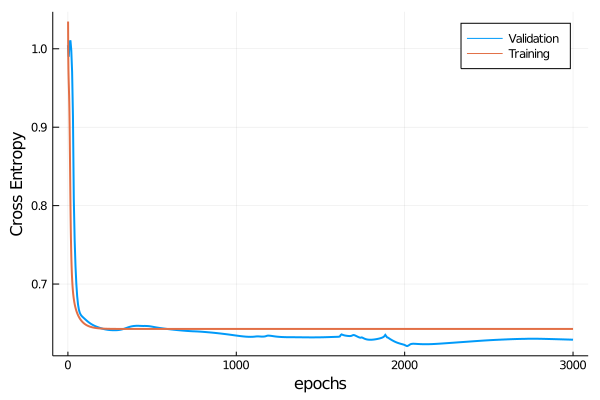

In [285]:
plot(curve.parameter_values,
     curve.measurements,
     xlab=curve.parameter_name,
     ylab="Cross Entropy",
     label="Validation", lw=2)
plot!(Net.report.training_losses, label="Training", lw=2)

In [286]:
a = round(nn.optimiser.eta, digits=5)
b = round(minimum(curve.measurements), digits=5)
best_epochs = curve.parameter_values[argmin(curve.measurements)]
a,b, best_epochs

(0.00033, 0.62092, 2015)

In [287]:
fn = "Figures/LearningCurve_NN_hidden:$(layer1)x$(layer2)_epochs:$(nn.epochs)_lr:$(a)_loss:$(b)_labmda:$(nn.lambda)"
png(replace(fn,'.' => ','))

### GridSearch for Hidden Layer Size 1

In [288]:
Net = machine(nn, X_stand, y)

Machine{NeuralNetworkClassifier{CustomNN,…}} @310 trained 0 times.
  args: 
    1:	Source @671 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @462 ⏎ `AbstractArray{Multiclass{3},1}`


In [289]:
param1 = :epochs
param2 = :(builder.n1)
# param2 = :(builder.n2)

r1 = range(nn, param1, lower=10, upper=1000, scale=:log10)
# r1 = range(nn, param1, lower=1, upper=100, scale=:linear)
r2 = range(nn, param2, lower=1, upper=100, scale=:linear)

MLJBase.NumericRange(Int64, :(builder.n1), ... )

In [290]:
self_tuning_nn_model = TunedModel(model=nn,
                                    tuning=Grid(goal=64),
                                    resampling=Holdout(fraction_train=0.7), 
                                    measure=cross_entropy,
                                    acceleration=CPUThreads(),
                                    range=[r1, r2])

ProbabilisticTunedModel(
    model = NeuralNetworkClassifier(
            builder = CustomNN @625,
            finaliser = NNlib.softmax,
            optimiser = ADAM(0.0003333333333333333, (0.9, 0.999), IdDict{Any,Any}()),
            loss = Flux.crossentropy,
            epochs = 3000,
            batch_size = 8,
            lambda = 0.01,
            alpha = 0.0,
            optimiser_changes_trigger_retraining = false),
    tuning = Grid(
            goal = 64,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = Holdout(
            fraction_train = 0.7,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = cross_entropy(
            eps = 2.220446049250313e-16),
    weights = nothing,
    operation = MLJModelInterface.predict,
    range = MLJBase.NumericRange{Int64,MLJBase.Bounded,Symbol}[NumericRange{Int64,…} @640, NumericRange{Int64,…} @223],
    train_best = true,
    repeats = 1,
    n

In [291]:
self_tuning_nn = machine(self_tuning_nn_model, X_stand, y)

Machine{ProbabilisticTunedModel{Grid,…}} @282 trained 0 times.
  args: 
    1:	Source @802 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @492 ⏎ `AbstractArray{Multiclass{3},1}`


In [292]:
z = fit!(self_tuning_nn, rows=train)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @282.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 64 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 64 metamodels: 100%[=========================] Time: 0:01:48


Machine{ProbabilisticTunedModel{Grid,…}} @282 trained 1 time.
  args: 
    1:	Source @802 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @492 ⏎ `AbstractArray{Multiclass{3},1}`


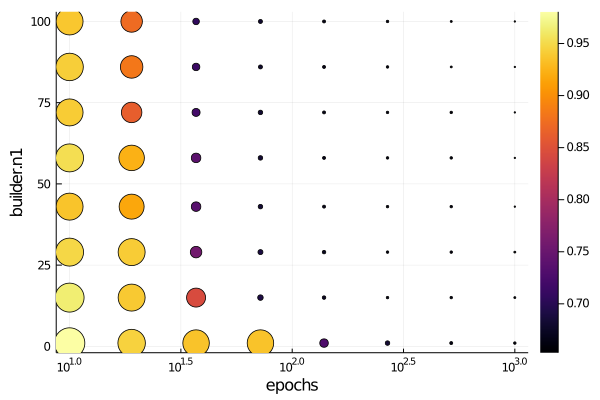

In [293]:
plot(self_tuning_nn)

In [294]:
best = fitted_params(self_tuning_nn)
best

(best_model = NeuralNetworkClassifier{CustomNN,…} @691,
 best_fitted_params = (chain = Chain(Chain(Dense(4, 72, σ), Dense(72, 40, σ), Dense(40, 3, σ)), softmax),),)

In [295]:
best.best_model

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 72,
            n2 = 40),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.0003333333333333333, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 1000,
    batch_size = 8,
    lambda = 0.01,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @691

In [296]:
best_loss = z.report.best_result.measurement[1]

0.65304273f0

In [297]:
best_n1 = best.best_model.builder.n1

72

In [298]:
fn = "Figures/Grid_NN_$(param1):$(best.best_model.epochs)_x_$(param2):$(best_n1)_bestloss:$(best_loss)"
f = replace(fn,'.' => ',')
png(f)

### GridSearch for Hidden Layer Size 2

In [299]:
nn = NeuralNetworkClassifier(builder=CustomNN(best_n1,layer2))

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 72,
            n2 = 40),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 10,
    batch_size = 1,
    lambda = 0.0,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @460

In [300]:
nn.optimiser.eta = 0.001
nn.epochs = 60
nn.batch_size = batch_sz
nn.lambda = 0.01

0.01

In [301]:
Net = machine(nn, X_stand, y)

Machine{NeuralNetworkClassifier{CustomNN,…}} @846 trained 0 times.
  args: 
    1:	Source @485 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @727 ⏎ `AbstractArray{Multiclass{3},1}`


In [302]:
param1 = :epochs
# param1 = :(builder.n1)
param2 = :(builder.n2)

r1 = range(nn, param1, lower=10, upper=3000, scale=:log10)
# r1 = range(nn, param1, lower=1, upper=100, scale=:linear)
r2 = range(nn, param2, lower=1, upper=100, scale=:linear)

MLJBase.NumericRange(Int64, :(builder.n2), ... )

In [303]:
self_tuning_nn_model = TunedModel(model=nn,
                                    tuning=Grid(goal=64),
                                    resampling=Holdout(fraction_train=0.7), 
                                    measure=cross_entropy,
                                    acceleration=CPUThreads(),
                                    range=[r1, r2])

ProbabilisticTunedModel(
    model = NeuralNetworkClassifier(
            builder = CustomNN @590,
            finaliser = NNlib.softmax,
            optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()),
            loss = Flux.crossentropy,
            epochs = 60,
            batch_size = 8,
            lambda = 0.01,
            alpha = 0.0,
            optimiser_changes_trigger_retraining = false),
    tuning = Grid(
            goal = 64,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = Holdout(
            fraction_train = 0.7,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = cross_entropy(
            eps = 2.220446049250313e-16),
    weights = nothing,
    operation = MLJModelInterface.predict,
    range = MLJBase.NumericRange{Int64,MLJBase.Bounded,Symbol}[NumericRange{Int64,…} @450, NumericRange{Int64,…} @186],
    train_best = true,
    repeats = 1,
    n = nothing,
    ac

In [304]:
self_tuning_nn = machine(self_tuning_nn_model, X_stand, y)

Machine{ProbabilisticTunedModel{Grid,…}} @229 trained 0 times.
  args: 
    1:	Source @029 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @233 ⏎ `AbstractArray{Multiclass{3},1}`


In [305]:
z = fit!(self_tuning_nn, rows=train)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @229.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 64 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 64 metamodels: 100%[=========================] Time: 0:05:57


Machine{ProbabilisticTunedModel{Grid,…}} @229 trained 1 time.
  args: 
    1:	Source @029 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @233 ⏎ `AbstractArray{Multiclass{3},1}`


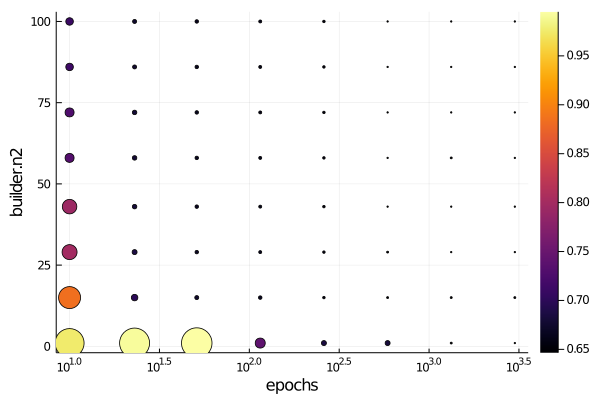

In [306]:
plot(self_tuning_nn)

In [307]:
best = fitted_params(self_tuning_nn)
best

(best_model = NeuralNetworkClassifier{CustomNN,…} @267,
 best_fitted_params = (chain = Chain(Chain(Dense(4, 72, σ), Dense(72, 29, σ), Dense(29, 3, σ)), softmax),),)

In [308]:
best.best_model

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 72,
            n2 = 29),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 1328,
    batch_size = 8,
    lambda = 0.01,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @267

In [309]:
best_loss = z.report.best_result.measurement[1]

0.64655924f0

In [310]:
best_n2 = best.best_model.builder.n2

29

In [311]:
fn = "Figures/Grid_NN_$(param1):$(best.best_model.epochs)_x_$(param2):$(best_n2)_bestloss:$(best_loss)"
png(replace(fn,'.' => ','))

### GridSearch for Learning Rate

In [312]:
nn = NeuralNetworkClassifier(builder=CustomNN(best_n1,best_n2))

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 72,
            n2 = 29),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 10,
    batch_size = 1,
    lambda = 0.0,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @864

In [313]:
nn.optimiser.eta = 0.001
nn.epochs = 60
nn.batch_size = batch_sz
nn.lambda = 0.01

0.01

In [314]:
Net = machine(nn, X_stand, y)

Machine{NeuralNetworkClassifier{CustomNN,…}} @302 trained 0 times.
  args: 
    1:	Source @636 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @368 ⏎ `AbstractArray{Multiclass{3},1}`


In [315]:
fit!(Net, rows=train, verbosity=1, force=true)

┌ Info: Training Machine{NeuralNetworkClassifier{CustomNN,…}} @302.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Optimising neural net:100%[=========================] Time: 0:00:00


Machine{NeuralNetworkClassifier{CustomNN,…}} @302 trained 1 time.
  args: 
    1:	Source @636 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @368 ⏎ `AbstractArray{Multiclass{3},1}`


In [316]:
param1 = :epochs
param2 = :(optimiser.eta)

r1 = range(nn, param1, lower=10, upper=1000, scale=:linear)
r2 = range(nn, param2, lower=0.0001, upper=0.1, scale=:log10)

MLJBase.NumericRange(Float64, :(optimiser.eta), ... )

In [317]:
self_tuning_nn_model = TunedModel(model=nn,
                                    tuning=Grid(goal=50),
                                    resampling=Holdout(fraction_train=0.7), 
                                    measure=cross_entropy,
                                    acceleration=CPUThreads(),
                                    range=[r1, r2])

ProbabilisticTunedModel(
    model = NeuralNetworkClassifier(
            builder = CustomNN @386,
            finaliser = NNlib.softmax,
            optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()),
            loss = Flux.crossentropy,
            epochs = 60,
            batch_size = 8,
            lambda = 0.01,
            alpha = 0.0,
            optimiser_changes_trigger_retraining = false),
    tuning = Grid(
            goal = 50,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = Holdout(
            fraction_train = 0.7,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = cross_entropy(
            eps = 2.220446049250313e-16),
    weights = nothing,
    operation = MLJModelInterface.predict,
    range = MLJBase.NumericRange{T,MLJBase.Bounded,Symbol} where T[NumericRange{Int64,…} @873, NumericRange{Float64,…} @647],
    train_best = true,
    repeats = 1,
    n = nothing,


In [318]:
self_tuning_nn = machine(self_tuning_nn_model, X_stand, y)

Machine{ProbabilisticTunedModel{Grid,…}} @471 trained 0 times.
  args: 
    1:	Source @551 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @997 ⏎ `AbstractArray{Multiclass{3},1}`


In [319]:
z = fit!(self_tuning_nn, rows=train)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @471.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 49 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 49 metamodels: 100%[=========================] Time: 0:02:13


Machine{ProbabilisticTunedModel{Grid,…}} @471 trained 1 time.
  args: 
    1:	Source @551 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @997 ⏎ `AbstractArray{Multiclass{3},1}`


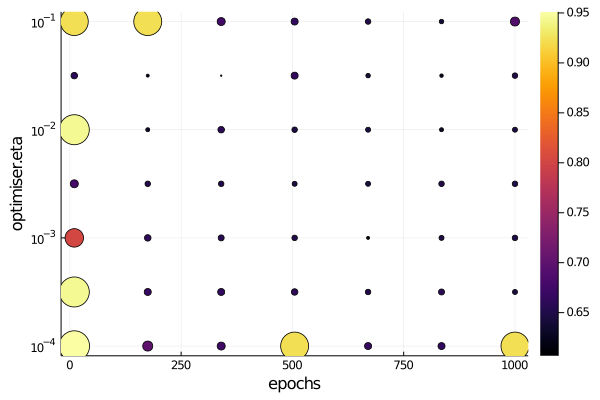

In [320]:
plot(self_tuning_nn)

In [321]:
best = fitted_params(self_tuning_nn)
best

(best_model = NeuralNetworkClassifier{CustomNN,…} @850,
 best_fitted_params = (chain = Chain(Chain(Dense(4, 72, σ), Dense(72, 29, σ), Dense(29, 3, σ)), softmax),),)

In [322]:
best.best_model

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 72,
            n2 = 29),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.03162277660168379, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 340,
    batch_size = 8,
    lambda = 0.01,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @850

In [323]:
best_loss = z.report.best_result.measurement[1]

0.6067952f0

In [324]:
best_eta = round(best.best_model.optimiser.eta, digits=5)

0.03162

In [325]:
fn = "Figures/Grid_NN_$(param1):$(best.best_model.epochs)_x_$(param2):$(best_eta)_bestloss:$(best_loss)_hidden:$b"
png(replace(fn,'.' => ','))

### GridSearch for Regularization

In [326]:
nn = NeuralNetworkClassifier(builder=CustomNN(best_n1,best_n2))

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 72,
            n2 = 29),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 10,
    batch_size = 1,
    lambda = 0.0,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @792

In [327]:
nn.optimiser.eta = best_eta
nn.epochs = 60
nn.batch_size = batch_sz
nn.lambda = 0.01

0.01

In [328]:
Net = machine(nn, X_stand, y)

Machine{NeuralNetworkClassifier{CustomNN,…}} @895 trained 0 times.
  args: 
    1:	Source @686 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @699 ⏎ `AbstractArray{Multiclass{3},1}`


In [329]:
param1 = :epochs
param2 = :lambda

r1 = range(nn, param1, lower=100, upper=2000, scale=:linear)
r2 = range(nn, param2, lower=0.0001, upper=10, scale=:log10)

MLJBase.NumericRange(Float64, :lambda, ... )

In [330]:
self_tuning_nn_model = TunedModel(model=nn,
                                    tuning=Grid(goal=50),
                                    resampling=Holdout(fraction_train=0.7), 
                                    measure=cross_entropy,
                                    acceleration=CPUThreads(),
                                    range=[r1, r2])

ProbabilisticTunedModel(
    model = NeuralNetworkClassifier(
            builder = CustomNN @074,
            finaliser = NNlib.softmax,
            optimiser = ADAM(0.03162, (0.9, 0.999), IdDict{Any,Any}()),
            loss = Flux.crossentropy,
            epochs = 60,
            batch_size = 8,
            lambda = 0.01,
            alpha = 0.0,
            optimiser_changes_trigger_retraining = false),
    tuning = Grid(
            goal = 50,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = Holdout(
            fraction_train = 0.7,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = cross_entropy(
            eps = 2.220446049250313e-16),
    weights = nothing,
    operation = MLJModelInterface.predict,
    range = MLJBase.NumericRange{T,MLJBase.Bounded,Symbol} where T[NumericRange{Int64,…} @889, NumericRange{Float64,…} @990],
    train_best = true,
    repeats = 1,
    n = nothing

In [331]:
self_tuning_nn = machine(self_tuning_nn_model, X_stand, y)

Machine{ProbabilisticTunedModel{Grid,…}} @003 trained 0 times.
  args: 
    1:	Source @797 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @294 ⏎ `AbstractArray{Multiclass{3},1}`


In [338]:
z = fit!(self_tuning_nn, rows=train)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @003.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 49 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 49 metamodels: 100%[=========================] Time: 0:06:47


Machine{ProbabilisticTunedModel{Grid,…}} @003 trained 1 time.
  args: 
    1:	Source @797 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @294 ⏎ `AbstractArray{Multiclass{3},1}`


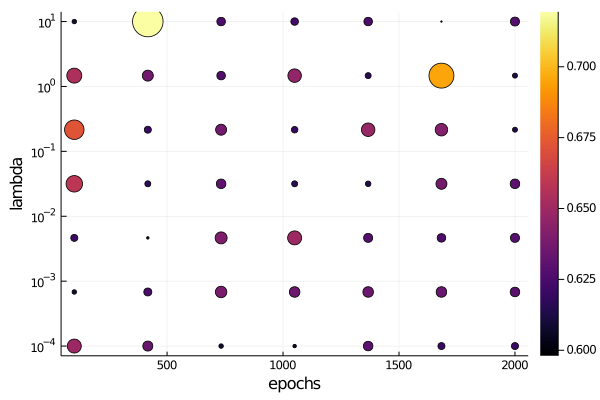

In [339]:
plot(self_tuning_nn)

In [340]:
best = fitted_params(self_tuning_nn)
best

(best_model = NeuralNetworkClassifier{CustomNN,…} @874,
 best_fitted_params = (chain = Chain(Chain(Dense(4, 72, σ), Dense(72, 29, σ), Dense(29, 3, σ)), softmax),),)

In [341]:
best.best_model

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 72,
            n2 = 29),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.03162, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 1683,
    batch_size = 8,
    lambda = 10.0,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @874

In [342]:
best_loss = z.report.best_result.measurement[1]

0.598047f0

In [343]:
best_lambda = best.best_model.lambda

10.0

In [344]:
fn = "Figures/Grid_NN_$(param1):$(best.best_model.epochs)_x_$(param2):$(best_lambda)_bestloss:$(best_loss)"
png(replace(fn,'.' => ','))

### Learning Curve

In [359]:
lc_model = NeuralNetworkClassifier(builder=CustomNN(best_n1,best_n2))
lc_model.optimiser.eta = best_eta;
lc_model.lambda = best_lambda
lc_model.epochs = 3000
lc_model.batch_size = batch_sz
lc_model

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 72,
            n2 = 29),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.03162, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 3000,
    batch_size = 32,
    lambda = 10.0,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @370

In [360]:
# lc_model = NeuralNetworkClassifier(builder=CustomNN(80,80))
# lc_model.optimiser.eta = 0.001;
# lc_model.lambda = best_lambda
# lc_model.epochs = 3000
# lc_model.batch_size = 8

In [361]:
data_schedule, training_losses, valid_losses = learn_curve(lc_model, X[train,:], y[train], acc)

(d, train_metric, valid_metric) = (10, 0.7, 0.42045454545454547)
(d, train_metric, valid_metric) = (15, 0.9333333333333333, 0.8522727272727273)
(d, train_metric, valid_metric) = (20, 0.95, 0.8295454545454546)
(d, train_metric, valid_metric) = (25, 1.0, 0.8522727272727273)
(d, train_metric, valid_metric) = (30, 1.0, 0.875)
(d, train_metric, valid_metric) = (35, 0.8857142857142857, 0.875)
(d, train_metric, valid_metric) = (40, 1.0, 0.8863636363636364)
(d, train_metric, valid_metric) = (45, 0.8666666666666667, 0.9090909090909091)
(d, train_metric, valid_metric) = (50, 1.0, 0.8863636363636364)
(d, train_metric, valid_metric) = (55, 1.0, 0.8863636363636364)
(d, train_metric, valid_metric) = (60, 1.0, 0.875)
(d, train_metric, valid_metric) = (65, 0.4153846153846154, 0.42045454545454547)
(d, train_metric, valid_metric) = (70, 0.8714285714285714, 0.9318181818181818)
(d, train_metric, valid_metric) = (75, 0.8666666666666667, 0.9318181818181818)
(d, train_metric, valid_metric) = (80, 0.9875, 0.8

(10:5:350, Any[0.7, 0.9333333333333333, 0.95, 1.0, 1.0, 0.8857142857142857, 1.0, 0.8666666666666667, 1.0, 1.0  …  0.9967213114754099, 1.0, 1.0, 0.9125, 0.9107692307692308, 0.9121212121212121, 0.9134328358208955, 0.9970588235294118, 0.9884057971014493, 0.9171428571428571], Any[0.42045454545454547, 0.8522727272727273, 0.8295454545454546, 0.8522727272727273, 0.875, 0.875, 0.8863636363636364, 0.9090909090909091, 0.8863636363636364, 0.8863636363636364  …  0.9659090909090909, 0.9545454545454546, 0.9545454545454546, 0.9431818181818182, 0.9431818181818182, 0.9545454545454546, 0.9545454545454546, 0.9545454545454546, 0.9090909090909091, 0.9318181818181818])

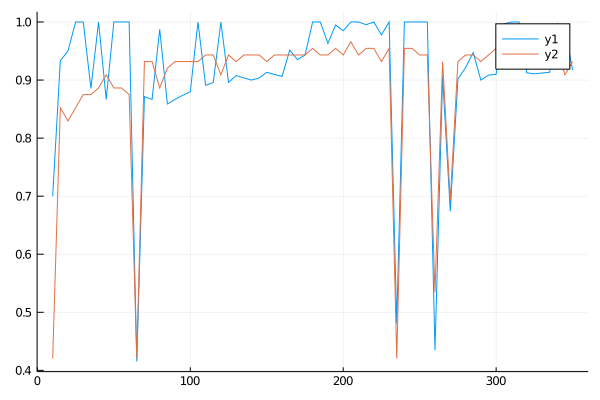

In [363]:
plot(data_schedule, training_losses)
plot!(data_schedule, valid_losses)

In [130]:
png("learning_curve_nn_3000epochs_balance")

# Final Results

In [364]:
final_model = NeuralNetworkClassifier(builder=CustomNN(best_n1,best_n2))

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 72,
            n2 = 29),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 10,
    batch_size = 1,
    lambda = 0.0,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @602

In [365]:
final_model.optimiser.eta = lc_model.optimiser.eta = best_eta;
final_model.batch_size = batch_sz
final_model.lambda = best_lambda
final_model.epochs = 3000

3000

In [230]:
final_model = NeuralNetworkClassifier(builder=CustomNN(80,80))
final_model.optimiser.eta = 0.01;
final_model.lambda = 0.1
final_model.epochs = 3000
final_model.batch_size = batch_sz

8

### Test Performance

In [366]:
Final_Net = machine(final_model, X_stand, y)

Machine{NeuralNetworkClassifier{CustomNN,…}} @899 trained 0 times.
  args: 
    1:	Source @425 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @638 ⏎ `AbstractArray{Multiclass{3},1}`


In [367]:
fit!(Final_Net, rows=train, force=true, verbosity=1)

┌ Info: Training Machine{NeuralNetworkClassifier{CustomNN,…}} @899.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Optimising neural net:100%[=========================] Time: 0:00:25


Machine{NeuralNetworkClassifier{CustomNN,…}} @899 trained 1 time.
  args: 
    1:	Source @425 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @638 ⏎ `AbstractArray{Multiclass{3},1}`


In [368]:
vals = collect(0:5:max_epochs)
r = range(final_model, :epochs, values=vals)
# r = range(nn, :epochs, lower=0, upper=max_epochs)
curve = learning_curve(Final_Net, 
                        range=r, 
                        resampling=Holdout(fraction_train=0.7), 
#                         resampling=CV(nfolds=4), 
                        measure=cross_entropy, 
                        acceleration=CPUThreads())

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @440.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 601 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 601 metamodels: 100%[=========================] Time: 0:00:28


(parameter_name = "epochs",
 parameter_scale = :none,
 parameter_values = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45  …  2955, 2960, 2965, 2970, 2975, 2980, 2985, 2990, 2995, 3000],
 measurements = [1.232387900352478, 0.9365378022193909, 0.6386847496032715, 0.6596091985702515, 0.6698125600814819, 0.6687132716178894, 0.6248385906219482, 0.6093200445175171, 0.6142428517341614, 0.6194220781326294  …  0.6145215034484863, 0.614519476890564, 0.6145173907279968, 0.6145153641700745, 0.6145133376121521, 0.6145113110542297, 0.6145092844963074, 0.614507257938385, 0.6145052313804626, 0.6145032048225403],)

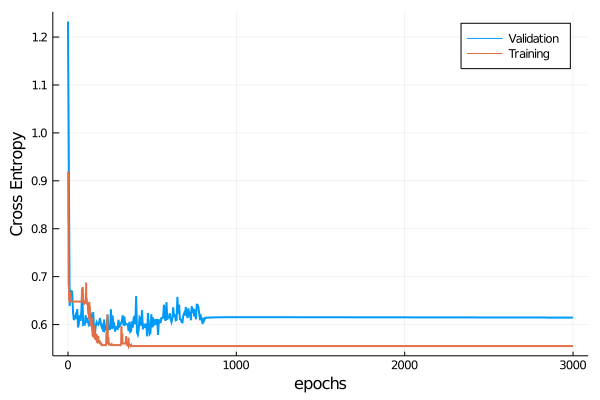

In [369]:
plot(curve.parameter_values,
     curve.measurements,
     xlab=curve.parameter_name,
     ylab="Cross Entropy",
     label="Validation", lw=2)
plot!(Final_Net.report.training_losses, label="Training", lw=2)

In [ ]:
nn_acc = evaluate!(Final_Net, resampling=CV(shuffle=true), measure=[cross_entropy, acc], verbosity=1)

Evaluating over 6 folds:  67%[================>        ]  ETA: 0:00:56

In [215]:
ŷ = MLJ.predict(Final_Net, X_stand[test,:]);

In [216]:
cross_entropy(ŷ, y[test]) |> mean

0.59533566f0

In [143]:
acc(ŷ, y[test])

0.9893048128342246

In [144]:
confusion_matrix(mode.(ŷ), y[test])

┌ Warning: The classes are un-ordered,
│ using order: ["B", "L", "R"].
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/measures/confusion_matrix.jl:87


              ┌─────────────────────────────────────────┐
              │              Ground Truth               │
┌─────────────┼─────────────┬─────────────┬─────────────┤
│  Predicted  │      B      │      L      │      R      │
├─────────────┼─────────────┼─────────────┼─────────────┤
│      B      │     15      │      2      │      0      │
├─────────────┼─────────────┼─────────────┼─────────────┤
│      L      │      0      │     84      │      0      │
├─────────────┼─────────────┼─────────────┼─────────────┤
│      R      │      0      │      0      │     86      │
└─────────────┴─────────────┴─────────────┴─────────────┘


In [145]:
fitted_params(Final_Net)

(chain = Chain(Chain(Dense(4, 86, σ), Dense(86, 5, σ), Dense(5, 3, σ)), softmax),)

In [146]:
report(Final_Net)

(training_losses = Any[0.93861085f0, 0.85701746f0, 0.742968f0, 0.7048983f0, 0.6880919f0, 0.6754444f0, 0.6683963f0, 0.66306496f0, 0.6590002f0, 0.6558289f0  …  0.5949696f0, 0.5949696f0, 0.5949696f0, 0.5949696f0, 0.5949696f0, 0.5949696f0, 0.5949696f0, 0.5949696f0, 0.5949696f0, 0.5949696f0],)

A lot slower than Holdout

In [ ]:
# self_tuning_nn_model = TunedModel(model=nn,
#                                     tuning=Grid(goal=50),
#                                     resampling=CV(), 
#                                     measure=cross_entropy,
#                                     acceleration=CPUThreads(),
#                                     range=[r_its, r_lr])

# self_tuning_nn = machine(self_tuning_nn_model, X_stand, y)

In [ ]:
# fit!(self_tuning_nn)

In [ ]:
# plot(self_tuning_nn)